# deltaSVM validation: gnomAD & phyloP

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors
from pylab import cm

In [2]:
df = pd.read_csv('/active/cherry_t/Leah/Analyses/gkm_svm/RandNeg_analysis/AltKernel/vcf/dsvm_AF.bg', delimiter='\t', low_memory=False, header=None)

In [3]:
# cleaning
df.columns = ['Chr', 'Start', 'End', 'Ref', 'Alt', 'DSVM', 'AF']
df.drop(df[df['AF'] == '.'].index, inplace = True)
df["AF"] = pd.to_numeric(df["AF"])

In [4]:
# add PHRED scaled dsvm to df
ranks = pd.Series.rank(df['DSVM'], ascending=False)
phred = -10*np.log10(ranks/len(ranks))
df.insert(7, 'PHRED', phred)

# add absval dsvm and PHRED scaled absval dsvm to df
abs_dsvm = abs(df['DSVM'])
abs_ranks = pd.Series.rank(abs_dsvm, ascending=False)
abs_phred = -10*np.log10(abs_ranks/len(abs_ranks))

df.insert(8, 'ABS_DSVM', abs_dsvm)
df.insert(9, 'ABS_PHRED', abs_phred)

In [5]:
print(df[df['DSVM'] > 10].shape)
print(df.shape)

(144, 10)
(512252, 10)


## Continuous deltaSVM vs AF Correlation

In [6]:
def getStats(bin_by, num_bins):
    bins = np.linspace(df[bin_by].min(), df[bin_by].max(), num_bins)
    groups = df.groupby(np.digitize(df[bin_by], bins))['AF']
    binned_af_mean = groups.mean()
    ci = 1.96*groups.sem()
    return dict(AF=binned_af_mean, ci=ci, bins=bins[binned_af_mean.index - 1])

In [7]:
statsDict = {}
for i in ["DSVM", "PHRED", "ABS_DSVM", "ABS_PHRED"]:
    statsDict[i] = getStats(i, 60)

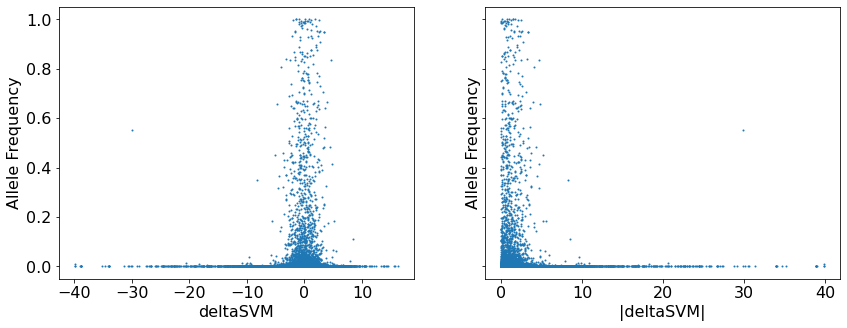

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,5))
randsample = df.sample(n=100000)

ax1.scatter(x=randsample['DSVM'], y=randsample['AF'], s=1)
ax1.set_xlabel('deltaSVM')
ax1.set_ylabel('Allele Frequency')


ax2.scatter(x=randsample['ABS_DSVM'], y=randsample['AF'], s=1)
ax2.set_xlabel('|deltaSVM|')
ax2.set_ylabel('Allele Frequency')


plt.show()

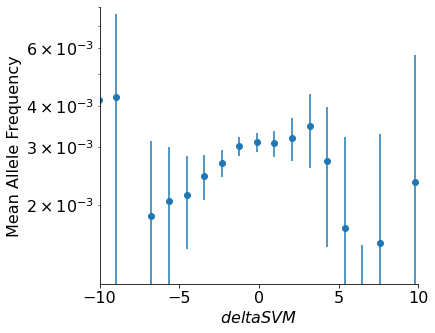

In [9]:
plt.figure(figsize=(11, 9))
plt.rcParams.update({'font.size': 16})

def plot_scatter(x, xlab, title):
    plt.scatter(x=statsDict[x]['bins'], y=statsDict[x]['AF'])
    plt.errorbar(x=statsDict[x]['bins'], y=statsDict[x]['AF'], yerr=statsDict[x]['ci'], ls='none')
    plt.yscale("log")
    plt.xlabel(xlab)
    plt.ylabel('Mean Allele Frequency')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
#     plt.title(title)

plt.subplot(221)
plt.xlim((-10,10))
plt.ylim((0.00115,0.008))
plot_scatter('DSVM', '$\it{deltaSVM}$', 'Raw deltaSVM vs gnomAD AF')


# plt.subplot(222)
# plot_scatter('PHRED', 'Scaled deltaSVM', 'Scaled deltaSVM vs gnomAD AF')

# plt.subplot(223)
# plot_scatter('ABS_DSVM', '|deltaSVM|', 'absval deltaSVM vs gnomAD AF')
# plt.xlim((0,6))
# plt.ylim((0.002,0.008))

# plt.subplot(224)
# plot_scatter('ABS_PHRED', 'Scaled |deltaSVM|', 'Scaled absval deltaSVM vs gnomAD AF')

plt.tight_layout()
plt.savefig('/active/cherry_t/Leah/Analyses/gkm_svm/RandNeg_analysis/AltKernel/AF_binnedDSVM_scatter.pdf')
plt.show()

In [10]:
statsDict['DSVM']['bins']

array([-39.8497    , -35.43667627, -34.33342034, -32.12690847,
       -31.02365254, -29.92039661, -28.81714068, -27.71388475,
       -26.61062881, -25.50737288, -24.40411695, -23.30086102,
       -22.19760508, -21.09434915, -19.99109322, -18.88783729,
       -17.78458136, -16.68132542, -15.57806949, -14.47481356,
       -13.37155763, -12.26830169, -11.16504576, -10.06178983,
        -8.9585339 ,  -7.85527797,  -6.75202203,  -5.6487661 ,
        -4.54551017,  -3.44225424,  -2.33899831,  -1.23574237,
        -0.13248644,   0.97076949,   2.07402542,   3.17728136,
         4.28053729,   5.38379322,   6.48704915,   7.59030508,
         8.69356102,   9.79681695,  10.90007288,  12.00332881,
        13.10658475,  14.20984068,  15.31309661,  16.41635254,
        17.51960847,  18.62286441,  19.72612034,  20.82937627,
        24.13914407,  25.2424    ])

## Categorical deltaSVM violinplots

In [11]:
df = df.sort_values("DSVM").reset_index(drop=True)
df

,Chr,Start,End,Ref,Alt,DSVM,AF,PHRED,ABS_DSVM,ABS_PHRED
0,chr11,115710523,115710524,A,T,-39.8497,0.000007,0.000042,39.8497,49.313324
1,chr11,115710521,115710522,A,T,-39.8497,0.000007,0.000042,39.8497,49.313324
2,chr19,4457811,4457812,A,T,-39.8497,0.000035,0.000042,39.8497,49.313324
3,chr19,4457810,4457811,A,T,-39.8497,0.000239,0.000042,39.8497,49.313324
4,chr5,65624721,65624722,T,A,-39.8497,0.000023,0.000042,39.8497,49.313324
...,...,...,...,...,...,...,...,...,...,...
512247,chr16,80540691,80540692,G,C,20.9873,0.000412,50.105137,20.9873,32.084244
512248,chr5,69043001,69043002,A,C,21.0586,0.000007,51.074237,21.0586,32.125540
512249,chr11,134045922,134045923,G,C,21.2089,0.000007,52.323624,21.2089,32.195252
512250,chr7,1176300,1176301,C,T,25.0355,0.000014,54.084537,25.0355,34.893756


In [12]:
# bin by percent - top, mid, bot 0.01%
# perc = 0.005
# size = int(df.shape[0] // (1 / (perc / 100)))
size = 200
bot = df.iloc[:size]
mid_idx = np.median(df[df['DSVM'] == 0].index)
# mid_idx = np.median(df[df['ABS_DSVM'].round() == 10].index)
mid = df.loc[mid_idx - size // 2 : mid_idx + size // 2]
top = df.iloc[-size:]

In [13]:
bot

,Chr,Start,End,Ref,Alt,DSVM,AF,PHRED,ABS_DSVM,ABS_PHRED
0,chr11,115710523,115710524,A,T,-39.8497,0.000007,0.000042,39.8497,49.313324
1,chr11,115710521,115710522,A,T,-39.8497,0.000007,0.000042,39.8497,49.313324
2,chr19,4457811,4457812,A,T,-39.8497,0.000035,0.000042,39.8497,49.313324
3,chr19,4457810,4457811,A,T,-39.8497,0.000239,0.000042,39.8497,49.313324
4,chr5,65624721,65624722,T,A,-39.8497,0.000023,0.000042,39.8497,49.313324
...,...,...,...,...,...,...,...,...,...,...
195,chr3,125766429,125766430,G,A,-24.0311,0.000239,0.001654,24.0311,34.128185
196,chr11,118930429,118930430,C,A,-23.9956,0.000007,0.001662,23.9956,34.106306
197,chr3,48442271,48442272,A,G,-23.9093,0.000009,0.001671,23.9093,34.084537
198,chr17,45135422,45135423,G,C,-23.8978,0.000007,0.001679,23.8978,34.062876


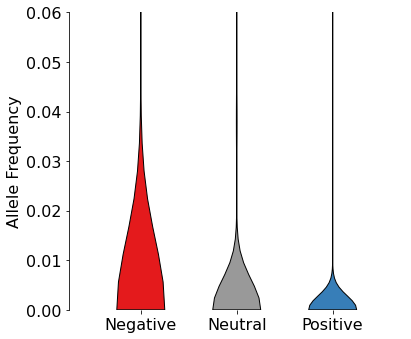

In [14]:
data = [bot['AF'], mid['AF'],top['AF']]
# data = [bot['AF'],top['AF']]

def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylabel('Allele Frequency')


# Create a figure instance 
fig = plt.figure(figsize=(6,5)) 
ax = fig.gca() 

# Create the violinplot 
parts = ax.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False)

colmap = cm.get_cmap('Set1', 10)
colors = colmap([0,0.8, 0.1])
for i in range(len(parts['bodies'])):
    parts['bodies'][i].set_facecolor(colors[i])
    parts['bodies'][i].set_edgecolor('black')
    parts['bodies'][i].set_alpha(1)

# set style for the axes
labels = ['Negative', 'Neutral', 'Positive']
# labels = ['Neutral', 'Extreme']
plt.ylim(0, 0.06)
set_axis_style(ax, labels)


plt.tight_layout()
plt.savefig('AF_absdsvm_violinplot.pdf')
plt.show() 

## deltaSVM vs. Phylop Conservation

In [2]:
cons_df = pd.read_csv('/active/cherry_t/Kelsey/Capstone/gkm_svm/bulk_ATAC_ChIP/validation_updated_copy/conservation/phylop20/phylop_isec.bedGraph', delimiter='\t', low_memory=False, header=None)
dsvm_df = pd.read_csv('/active/cherry_t/Leah/Analyses/gkm_svm/RandNeg_analysis/AltKernel/bedgraphs/dsvm_muts_trim.bedgraph', delimiter='\t', low_memory=False, header=None)

In [3]:
cons_df.columns = "chr start stop cons".split()
dsvm_df.columns = "chr start stop dsvm ref alt".split()
dsvm_df = dsvm_df[dsvm_df.ref != dsvm_df.alt]
merged_df = dsvm_df.merge(cons_df, on='start', how='left')
merged_df = merged_df.dropna()

In [4]:
merged_df = merged_df.sort_values('dsvm').reset_index(drop=True)

In [5]:
merged_df

,chr_x,start,stop_x,dsvm,ref,alt,chr_y,stop_y,cons
0,chr8,94958534,94958535,-39.84966,T,A,chr8,94958535.0,0.505
1,chr19,4457809,4457810,-39.84966,A,T,chr19,4457810.0,0.107
2,chr11,119085182,119085183,-39.84966,T,A,chr11,119085183.0,0.448
3,chr19,4457808,4457809,-39.84966,A,T,chr19,4457809.0,0.107
4,chr19,4457807,4457808,-39.84966,A,T,chr19,4457808.0,0.107
...,...,...,...,...,...,...,...,...,...
19980623,chr12,56284337,56284338,38.83421,G,A,chr12,56284338.0,-1.568
19980624,chr9,86948026,86948027,38.83421,C,T,chr9,86948027.0,-0.912
19980625,chr7,120950761,120950762,38.83421,C,T,chr7,120950762.0,-0.870
19980626,chr18,28174254,28174255,38.83421,G,A,chr18,28174255.0,-3.585


In [6]:
perc = 0.01
size = int(merged_df.shape[0] //  (1 / (perc / 100)))
bot = merged_df.iloc[:size]
mid_idx = np.median(merged_df[merged_df['dsvm'] == 0].index)
mid = merged_df.loc[mid_idx - size // 2 : (mid_idx + size // 2) - 1]
top = merged_df.iloc[-size:]

In [7]:
mid

,chr_x,start,stop_x,dsvm,ref,alt,chr_y,stop_y,cons
10776411,chr4,185787981,185787982,-0.00018,G,T,chr4,185787982.0,-0.233
10776412,chr20,11890998,11890999,-0.00018,T,G,chr20,11890999.0,0.879
10776413,chr14,81276564,81276565,-0.00018,T,A,chr14,81276565.0,0.868
10776414,chr14,69191594,69191595,-0.00018,A,C,chr14,69191595.0,1.194
10776415,chr16,1612265,1612266,-0.00018,G,C,chr16,1612266.0,0.695
...,...,...,...,...,...,...,...,...,...
10778403,chr18,34659772,34659773,0.00018,G,C,chr18,34659773.0,-0.239
10778404,chr7,2157833,2157834,0.00018,T,G,chr7,2157834.0,0.735
10778405,chr19,13833671,13833672,0.00018,C,T,chr19,13833672.0,-0.139
10778406,chr16,27701695,27701696,0.00018,G,C,chr16,27701696.0,1.048


AxisError: axis 1 is out of bounds for array of dimension 1

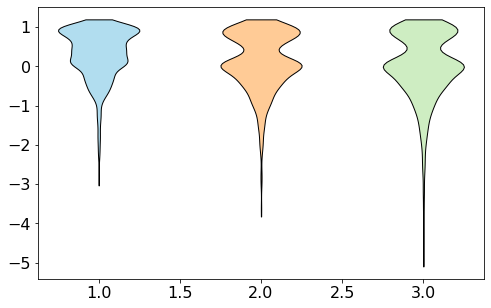

In [8]:
data = [sorted(item) for item in [bot['cons'], mid['cons'], top['cons']]]

# Create a figure instance 
fig = plt.figure(figsize=(8,5)) 
ax = fig.gca() 


def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)


parts = ax.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False)

colors = ['#B1DDEF', '#FFCB96', '#CEEDC2']
for i in range(len(parts['bodies'])):
    parts['bodies'][i].set_facecolor(colors[i])
    parts['bodies'][i].set_edgecolor('black')
    parts['bodies'][i].set_alpha(1)

quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
whiskers = np.array([adjacent_values(sorted_array, q1, q3) for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# set style for the axes
labels = ['Negative', 'Neutral', 'Positive']
set_axis_style(ax, labels)
plt.ylim(-3, 1.5)
plt.ylabel('phyloP Conservation')


plt.savefig('/active/cherry_t/Leah/Analyses/gkm_svm/RandNeg_analysis/AltKernel/DSVM_phylop_plot.pdf')
plt.show() 

## deltaSVM vs. gnomAD Indel Frequency

In [3]:
af = pd.read_csv('/active/cherry_t/Kelsey/Capstone/gkm_svm/bulk_ATAC_ChIP/validation_updated_copy/varfreq/all_cres/1kb/indels/counts/gnomad_indels_intersect.bg', delimiter='\t', low_memory=False, header=None)

In [10]:
dsvm = pd.read_csv('/active/cherry_t/Leah/Analyses/gkm_svm/RandNeg_analysis/FullRandom/bedgraphs/summed_ATAC_ChIP_scored_disease_nt.bedGraph',  sep='\t', header=None)

In [11]:
af.columns='chr start stop AF'.split()
dsvm.columns='chr start stop dsvm'.split()

In [12]:
def aggr(window_size, vec):
    window_size = window_size
    n_windows = len(vec)//window_size

    vec = np.array(vec)
    vec.shape = (n_windows, window_size)
    aggr = vec.sum(axis=0)/n_windows
    print(len(aggr))
    return aggr

In [13]:
indel_aggr = aggr(1001, af['AF'])
dsvm_aggr = aggr(301, dsvm['dsvm'])

1001
301


[[1.         0.87664909]
 [0.87664909 1.        ]]


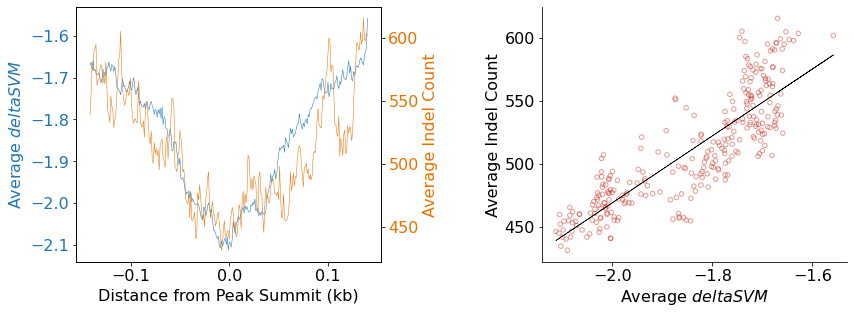

In [14]:
fig, (ax1,ax3) = plt.subplots(1, 2, figsize=(13,5.5))
colors = cm.get_cmap('tab20', 20)

crop = 10
dsvm_aggr_crop = dsvm_aggr[crop:-crop + 1]
indel_aggr_crop = indel_aggr[500 - len(dsvm_aggr_crop)//2 : 500 + len(dsvm_aggr_crop)//2]
x = np.arange(-len(dsvm_aggr_crop)/2000, len(dsvm_aggr_crop)/2000, 1/1000)

# plot dsvm trend
ax1.plot(x, dsvm_aggr_crop, linewidth=0.5, color=colors(0))
ax1.set_xlabel('Distance from Peak Summit (kb)')
ax1.set_ylabel('Average $\it{deltaSVM}$', color=colors(0))
ax1.tick_params(axis='y', labelcolor=colors(0))

# plot indel count trend
ax2 = ax1.twinx()
ax2.plot(x, indel_aggr_crop, linewidth=0.5, color='#EB7200')
ax2.set_ylabel('Average Indel Count', color='#EB7200')
ax2.tick_params(axis='y', labelcolor='#EB7200')

# scatterplot  dsvm vs indel count
dsvm_rank = pd.Series.rank(pd.Series(dsvm_aggr_crop))
indel_rank = pd.Series.rank(pd.Series(indel_aggr_crop))
print(np.corrcoef(dsvm_rank, indel_rank))

m, b = np.polyfit(dsvm_aggr_crop, indel_aggr_crop, 1)
ax3.plot(dsvm_aggr_crop, m*dsvm_aggr_crop + b, color='k', linewidth=0.6)
ax3.scatter(dsvm_aggr_crop, indel_aggr_crop, s=20, alpha=0.45, edgecolor='#C1281A', facecolor='none')
ax3.set_ylabel('Average Indel Count')
ax3.set_xlabel('Average $\it{deltaSVM}$')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)


plt.tight_layout(pad=3)
plt.savefig('/active/cherry_t/Leah/Analyses/gkm_svm/RandNeg_analysis/FullRandom/masterplot_aggr_dsvm_vs_indelcount_1kb.pdf')
plt.show()